In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

This uses the default main branch of whr. e.g. it will use "black/white" to refer to the winner. "White" is second. 

In [2]:
data_path = '../data/cfbd/games_1990_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
#games_df = games_df[games_df.season>2010]
games_df.shape

(23256, 25)

win_prob with 2.5 home field =  1/(1+10^(2.5/13))
win_prob with 400 elo scale =  1/(1+10^(x/400))

elo handicap for 2.5 points = 2.5/13 * 400 = 77

In [4]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")

In [5]:
scale = 13
w2 = (300*scale**2)/(400**2)
whr = whole_history_rating.Base({'scale': scale,'w2':w2, 'debug':False})

In [6]:
start_time = 0
home_team_handicap = 2.5/13*scale
verbose = False
for i,row in games_df.iterrows():
    game_time = datetime_from_cfbd(row.start_date)
    if start_time == 0: start_time = game_time
    days = (game_time-start_time).days
    home_team = row.home_team
    away_team = row.away_team
    handicap = -(1-row.neutral_site)*home_team_handicap
    mov = row.home_points-row.away_points
    winner = "W" if mov>0 else "B"
    if mov==0: continue
        
    if verbose: print("away team: {}, home team: {}".format(away_team,home_team))
    if verbose: print("winner: {} (W is home), days: {} handicap: {}".format(winner,days,handicap))
    whr.create_game(away_team,home_team,winner, days, handicap)
    #if len(whr.games) > 100: break

In [7]:
len(whr.games)

23179

timing:

100 games: 0.21831806499903905

1000:      4.505260759000521

8332:      15.015844893998292

23179:     58.9916944889992

In [8]:
start_perf_timer = time.perf_counter()
whr.auto_iterate(time_limit = 10, precision = 10E-4*scale/400)
end_perf_timer = time.perf_counter()
end_perf_timer-start_perf_timer

60.373399545998836

In [9]:
def get_player_history(player_name,start_time=0, seasons=[]):
    ratings = whr.ratings_for_player(player_name)
    if start_time:
        ratings = [[dt.timedelta(days=d)+start_time,elo,unc] for d,elo,unc in ratings]
    return ratings

In [10]:
players = [
           'Texas A&M',
           'Texas',
           'Alabama',
           'Minnesota',
           'LSU',
           'Vanderbilt'
          ]

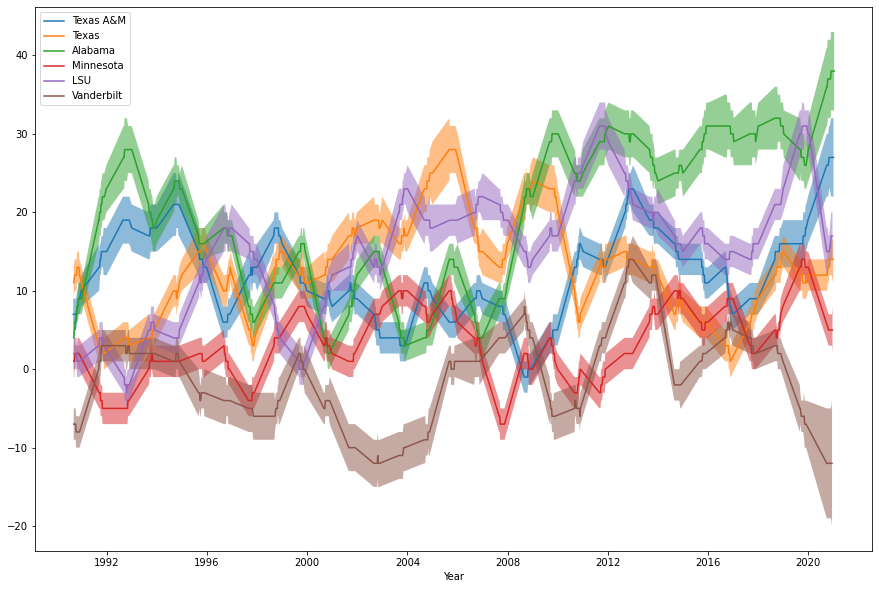

In [11]:
fig = plt.figure(figsize=[15,10])
for player in players:
    player_details = get_player_history(player,start_time=start_time)
    dates,ratings,uncertainties = list(zip(*player_details))
    ratings,uncertainties = np.asarray(ratings),np.asarray(uncertainties)
    plt.plot(dates,ratings,label=player)
    up,down = ratings+uncertainties, ratings-uncertainties
    plt.fill_between(dates,up,down, alpha=.5)
plt.legend()
plt.xlabel('Year')
plt.savefig('scale_{}_w_{}.png'.format(scale,w2))

In [12]:
whr.print_ordered_ratings(current=True)

VMI => -43.718148382884884
Morgan State => -40.14638809889215
Murray State => -38.503919853419866
Texas Southern => -38.471685403303084
Austin Peay => -38.41049661870494
Stephen F. Austin => -38.118720198417954
Rhode Island => -37.700490268412494
Tennessee Tech => -37.66403053391868
Southeast Missouri State => -37.236341200304345
Western Carolina => -36.89964017058166
Missouri State => -36.58947437831337
Southeastern Louisiana => -36.36454501685092
Weber State => -36.277167418178706
Prairie View => -35.30504805793349
Norfolk State => -35.22449779449394
Southern => -33.853112016267715
East Tennessee State => -33.816639030866014
Charleston Southern => -33.71686970686682
Alcorn State => -33.31456156547777
Abilene Christian => -32.8474601481955
Grambling => -32.79849388564456
Wagner => -32.5674008889408
Houston Baptist => -32.06653589792518
Jackson State => -31.154250116068816
Northern Colorado => -31.115462963821084
Mississippi Valley State => -31.08337225564166
Bucknell => -31.0463170161